In [1]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, mean_squared_error, mean_absolute_error, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import optuna

import numpy as np

pd.options.display.float_format = '{:.2f}'.format
random.seed(42)
np.random.seed(42)

In [2]:
# Если возникают проблемы с catboost то понизь версию numpy.
#%pip install numpy==1.9

In [3]:
# Попытка ускорить svc
# python меньше 3.10
#!python3 --version
#!python3 -m pip install --upgrade pip --break-system-packages
#!python3 -m pip install scikit-learn-intelex --break-system-packages


In [4]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [5]:
df = pd.read_csv('modified_train.csv', index_col=0)

In [6]:
df['ctws'].fillna('', inplace=True)

/var/folders/v9/61pbr9j16zx7f0dxmvmrh7500000gn/T/ipykernel_63194/3334934365.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ctws'].fillna('', inplace=True)


In [7]:
X = df['ctws']
y = df['toxicity_b']

Разделение на train/val/test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Давайте посмотрим на распределение выборок

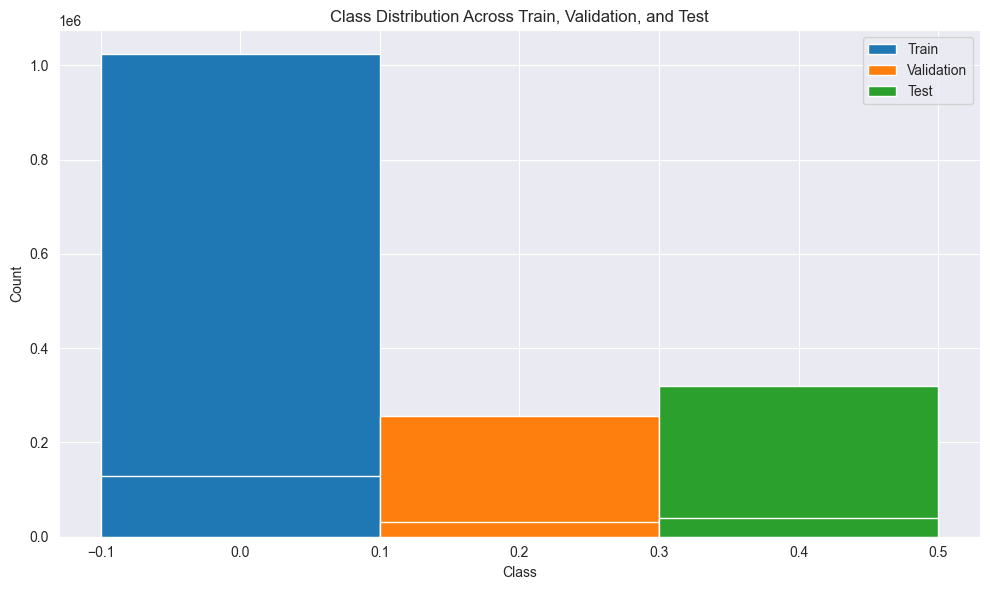

In [9]:
import numpy as np

datasets_labels = ['Train', 'Validation', 'Test']
distributions = [
    np.bincount(y_train),
    np.bincount(y_val),
    np.bincount(y_test)
]

bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, dist in enumerate(distributions):
    ax.bar(
        i * bar_width, dist, bar_width, label=datasets_labels[i]
    )

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Across Train, Validation, and Test')
ax.legend()

plt.tight_layout()
plt.show()


Разбиение на train и test выборки по Out-Of-Time (OOT) 

In [10]:
split_date = "2017-04-01"

train_data = df[df['created_date'] < split_date]
test_data = df[df['created_date'] >= split_date]

Для разбиения на train и val выборки будем использовать In-Sample

In [11]:
X = train_data['ctws']
y = train_data['toxicity_b']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [12]:
# Test данные
X_test = test_data['ctws']
y_test = test_data['toxicity_b']

In [13]:
# Функция обучения модели и предсказания и визуализации результатов
def logistic_regression_objective(trial, X_train, X_val, y_train, y_val):
    # Подбор гиперпараметров
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)  # Регуляризация
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])  # Тип регуляризации

    solver = 'liblinear' if penalty in ['l1', 'l2'] else 'saga'

    # Создаём модель
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000,
    )

    # Обучение модели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Рассчитываем метрики
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    trial.set_user_attr("auc_roc", auc_roc)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)


    return f1


def naive_bayes_objective(trial, X_train, X_val, y_train, y_val):
    # Параметры Naive Bayes
    # MultinomialNB чаще используется для текстовых данных
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)

    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Сохраняем метрики для каждого испытания
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('auc_roc', auc_roc)
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)

    return f1



# Функция получения мешка слов
def get_bows(X_train, X_val, X_test=None):
    vectorizer = CountVectorizer()

    X_train_bow = vectorizer.fit_transform(X_train)
    X_val_bow = vectorizer.transform(X_val)

    # Если переданы тестовые данные, также трансформируем их
    X_test_bow = vectorizer.transform(X_test) if X_test is not None else None

    return X_train_bow, X_val_bow, X_test_bow


# Векторизация  TF-IDF
def get_tfidf(X_train, X_val, X_test):
    vectorizer = TfidfVectorizer()
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test) if X_test is not None else None

    return X_train_tfidf, X_val_tfidf, X_test_tfidf

def svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    svc = SVC(C=C, kernel='linear', probability=True)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)
    y_pred_proba = svc.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Логируем метрики в user_attrs
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("auc_roc", auc_roc)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

    return f1



Настраиваем Boosting для устранения смещения

In [28]:
def make_boosting_with_report(X_train, X_val, y_train, y_val):
    # Обучение модели CatBoost
    model = CatBoostClassifier(
        iterations=100,     # Количество итераций
        depth=5,            # Максимальная глубина деревьев
        learning_rate=0.1,  # Скорость обучения
        verbose=0           # Отключить вывод логов во время обучения
    )

    model.fit(X_train, y_train)

    # Предсказания
    y_pred = model.predict(X_val)

    # Метрики
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Пример на одном объекте
    sample = X_val.iloc[[0]]
    print(f"Features: {sample}")
    print(f"Predicted Class: {model.predict(sample)[0]}")
    print(f"Predicted Probability: {model.predict_proba(sample)[0]}")




# Обучение с мешком слов

In [15]:
X_train_bow, X_val_bow, X_test_bow = get_bows(X_train, X_val, X_test)


### Логистическая регрессия

In [16]:
# Запуск Optuna
def launch_optuna(trial):
    return logistic_regression_objective(trial, X_train_bow, X_val_bow, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Попытка {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")

[I 2024-12-04 16:45:32,531] A new study created in memory with name: no-name-6344be78-571a-435b-b8bf-ca291ef6fd47
[I 2024-12-04 16:45:45,830] Trial 0 finished with value: 0.5699405311565028 and parameters: {'C': 0.14949894406828093, 'penalty': 'l2'}. Best is trial 0 with value: 0.5699405311565028.
[I 2024-12-04 16:45:50,805] Trial 1 finished with value: 0.5730884071141114 and parameters: {'C': 37.26481397980149, 'penalty': 'l1'}. Best is trial 0 with value: 0.5699405311565028.


Попытка 0:
  AUC-ROC: 0.9143892865082408
  Precision: 0.7630303629710217
  Recall: 0.4548402311048225
  Best Params: {'C': 0.14949894406828093, 'penalty': 'l2'}
Попытка 1:
  AUC-ROC: 0.860559150207518
  Precision: 0.6374729241877256
  Recall: 0.5205164485320127
  Best Params: {'C': 37.26481397980149, 'penalty': 'l1'}


### SVM - используем SVC

In [ ]:
def launch_optuna_svc(trial):
    return svc_objective(trial, X_train_bow, X_val_bow, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna_svc, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Trial {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")

[I 2024-12-04 16:45:50,809] A new study created in memory with name: no-name-91ba29e7-b625-4709-935c-de48a340d9f4


### Наивный Байес (Наивный байесовский классификатор)

In [16]:
def launch_optuna_naive_bayes(trial):
    return naive_bayes_objective(trial, X_train_bow, X_val_bow, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna_naive_bayes, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Trial {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")


[I 2024-12-04 16:49:49,640] A new study created in memory with name: no-name-978d5300-9730-44a8-9a91-8ddf3dc04913
[I 2024-12-04 16:49:49,913] Trial 0 finished with value: 0.5139885133969286 and parameters: {'alpha': 0.01179635144991194}. Best is trial 0 with value: 0.5139885133969286.
[I 2024-12-04 16:49:50,097] Trial 1 finished with value: 0.5100697807246268 and parameters: {'alpha': 0.0035737476959786085}. Best is trial 1 with value: 0.5100697807246268.


Trial 0:
  AUC-ROC: 0.8313334810888722
  Precision: 0.4416486635320032
  Recall: 0.6146680815941516
  Best Params: {'alpha': 0.01179635144991194}
Trial 1:
  AUC-ROC: 0.8233292035880386
  Precision: 0.4406401510275883
  Recall: 0.6054710529418701
  Best Params: {'alpha': 0.0035737476959786085}


### Применяем Boosting с Мешком слов

In [29]:
make_boosting_with_report(X_train_bow, X_val_bow, y_train, y_val)

Accuracy: 0.9102712356576598

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95    138696
           1       0.84      0.22      0.35     16962

    accuracy                           0.91    155658
   macro avg       0.88      0.61      0.65    155658
weighted avg       0.90      0.91      0.89    155658



AttributeError: 'csr_matrix' object has no attribute 'iloc'

# Обучение с TF-IDF

In [20]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = get_tfidf(X_train, X_val, X_test)

### Логистическая регрессия

In [21]:
# Запуск Optuna
def launch_optuna(trial):
    return logistic_regression_objective(trial, X_train_tfidf, X_val_tfidf, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Попытка {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")

[I 2024-12-04 16:55:39,244] A new study created in memory with name: no-name-4d494d0a-ef96-46c1-a8eb-40c92331b275
[I 2024-12-04 16:55:43,462] Trial 0 finished with value: 0.4708929557131332 and parameters: {'C': 0.1471819863421775, 'penalty': 'l2'}. Best is trial 0 with value: 0.4708929557131332.
[I 2024-12-04 16:55:51,372] Trial 1 finished with value: 0.6023115975947863 and parameters: {'C': 2.6285707494831505, 'penalty': 'l2'}. Best is trial 0 with value: 0.4708929557131332.


Попытка 0:
  AUC-ROC: 0.9262906985993283
  Precision: 0.8415541053270602
  Recall: 0.32690720433911097
  Best Params: {'C': 0.1471819863421775, 'penalty': 'l2'}
Попытка 1:
  AUC-ROC: 0.9335683980862746
  Precision: 0.7736564610119323
  Recall: 0.49310222851078883
  Best Params: {'C': 2.6285707494831505, 'penalty': 'l2'}


### SVM

In [ ]:
def launch_optuna_svc(trial):
    return svc_objective(trial, X_train_tfidf, X_val_tfidf, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna_svc, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Trial {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")

### Наивный Байес (Наивный байесовский классификатор)

In [23]:
def launch_optuna_naive_bayes(trial):
    return naive_bayes_objective(trial, X_train_tfidf, X_val_tfidf, y_train, y_val)

study = optuna.create_study(direction="minimize")
study.optimize(launch_optuna_naive_bayes, n_trials=2)

trials = study.trials

for trial in trials:
    print(f"Trial {trial.number}:")
    print(f"  AUC-ROC: {trial.user_attrs.get('auc_roc')}")
    print(f"  Precision: {trial.user_attrs.get('precision')}")
    print(f"  Recall: {trial.user_attrs.get('recall')}")
    print(f"  Best Params: {trial.params}")

[I 2024-12-04 16:58:57,283] A new study created in memory with name: no-name-9129e714-de70-4c3c-80c2-12255da97d44
[I 2024-12-04 16:58:57,523] Trial 0 finished with value: 0.23453098869913344 and parameters: {'alpha': 0.02305846000789662}. Best is trial 0 with value: 0.23453098869913344.
[I 2024-12-04 16:58:57,709] Trial 1 finished with value: 0.23575103399576314 and parameters: {'alpha': 0.005533153251493821}. Best is trial 0 with value: 0.23453098869913344.


Trial 0:
  AUC-ROC: 0.85020271023285
  Precision: 0.8350775893179357
  Recall: 0.13642259167550996
  Best Params: {'alpha': 0.02305846000789662}
Trial 1:
  AUC-ROC: 0.8342722016482228
  Precision: 0.8159916201117319
  Recall: 0.13777856384860276
  Best Params: {'alpha': 0.005533153251493821}


### Применяем Boosting с TF-IDF


In [30]:
make_boosting_with_report(X_train_tfidf, X_val_tfidf, y_train, y_val)

Accuracy: 0.9130915211553534

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    138696
           1       0.87      0.24      0.37     16962

    accuracy                           0.91    155658
   macro avg       0.89      0.62      0.66    155658
weighted avg       0.91      0.91      0.89    155658



AttributeError: 'csr_matrix' object has no attribute 'iloc'